In [1]:
import numpy as np
import matplotlib.pyplot as plt

import spacetimeformer as stf
import pytorch_lightning as pl
import numpy as np
from scipy.stats import chi2, norm, beta, gamma
import matplotlib.pyplot as plt
import math
import pandas as pd
import os

import sys
from contextlib import contextmanager


from collections import defaultdict
import re
import pickle
from tqdm.notebook import tqdm

In [2]:
def q_data(config, m=0):
    m=0
    sigfig = 2
    fs = 2048  # Sampling rate (Hz)
    T = 150  # Length of epochs (s)

    # Set the seed for reproducibility
    np.random.seed(42)

    # Define the number of iterations for the simulation
    n_iterations = fs * T
    # Preallocate the arrays for the x variables
    x1 = np.zeros(n_iterations)
    x2 = np.zeros(n_iterations)
    x3 = np.zeros(n_iterations)
    x4 = np.zeros(n_iterations)
    x5 = np.zeros(n_iterations)

    # Define the rate lambda for the exponential distribution
    lambda_rate = 2

    # Generate the noise processes e1t, e2t, e3t, e4t, e5t
    e1 = np.random.exponential(scale=1 / lambda_rate, size=n_iterations)
    e2 = chi2.rvs(df=1, size=n_iterations)
    # e1 = norm.rvs(scale=1, size=n_iterations)
    # e2 = norm.rvs(scale=1, size=n_iterations)
    e3 = norm.rvs(scale=1, size=n_iterations) *m # Gaussian with mean 0, std 1
    e4 = norm.rvs(scale=1, size=n_iterations) *m # Gaussian with mean 0, std 1
    e5 = norm.rvs(scale=1, size=n_iterations) *m# Gaussian with mean 0, std 1

    e1 = np.round(e1, sigfig)
    e2 = np.round(e2, sigfig)
    e3 = np.round(e3, sigfig)
    e4 = np.round(e4, sigfig)
    e5 = np.round(e5, sigfig)

    for t in range(6, n_iterations):
        x1[t] = e1[t]
        x2[t] = e2[t]
        x3[t] = 0.8 * x2[t] + e3[t]
        x4[t] = 0.7 * x1[t] * (math.pow(x1[t], 2) - 1) * np.exp((-math.pow(x1[t], 2)) / 2) + e4[t]
        x5[t] = 0.3 * x2[t] + 0.05 * math.pow(x2[t], 2) + e5[t]

    x3 = np.round(x3, sigfig)
    x4 = np.round(x4, sigfig)
    x5 = np.round(x5, sigfig)

    PLOT_VAR_NAMES = np.arange(5) + 1
    PLOT_VAR_IDXS = np.arange(5)

    data = np.array([x1, x2, x3, x4, x5]).T
    data= data[100:]
    df = pd.DataFrame(data, columns=PLOT_VAR_NAMES)
    df["Datetime"] = pd.date_range(start="1/1/2020", periods=df.shape[0], freq="s")

    dset = stf.data.CSVTimeSeries(
        data_path=None,
        raw_df=df,
        val_split=0.1,
        test_split=0.1,
        normalize=True,
        time_col_name="Datetime",
        time_features=["minute", 'second', 'millisecond'],
    )
    yc_dim = data.shape[1]
    yt_dim = data.shape[1]
    x_dim = dset.time_cols.shape[0]

    DATA_MODULE = stf.data.DataModule(
        datasetCls=stf.data.CSVTorchDset,
        dataset_kwargs={
            "csv_time_series": dset,
            "context_points": config['context_points'],
            "target_points": config['target_points'],
            "time_resolution": config['time_resolution'],
        },
        batch_size=config['batch_size'],
        workers=config['workers'],
        overfit=False,
    )
    INV_SCALER = dset.reverse_scaling
    SCALER = dset.apply_scaling
    NULL_VAL = None
    return DATA_MODULE

In [3]:
default_config = {
    # fixed but maybe change...
    'batch_size': 2000,
    'workers': 6,
    'init_lr': 1e-10,
    'base_lr': 0.0005,
    'context_points': 32,
    'target_points': 1,
    'd_model': 100,
    'd_qk': 100,
    'd_v': 100,
    'd_ff': 400,
    'n_heads': 1,
    'enc_layers': 1,
    'dec_layers': 1,
    'global_self_attn': 'full',
    'local_self_attn': 'full',
    'global_cross_attn': 'full',
    'local_cross_attn': 'full',
    'no_val': False,
    'no_time': False,
    'no_space': False,
    'no_given': False,

    # directly set parameters
    'gpus': [0],
    # 'gpus':None,
    'strategy': 'dp',
    "time_resolution": 1,
    "start_token_len": 0,
    "attn_factor": 5,
    "dropout_emb": 0.2,
    "dropout_attn_out": 0,
    "dropout_attn_matrix": 0,
    "dropout_qkv": 0,
    "dropout_ff": 0.3,
    "pos_emb_type": 'abs',
    "no_final_norm": False,
    "performer_kernel": 'relu',
    "performer_redraw_interval": 100,
    "attn_time_windows": 1,
    "use_shifted_time_windows": False,
    "norm": 'batch',
    "activation": 'gelu',
    "warmup_steps": 0,
    "decay_factor": 0.25,
    "initial_downsample_convs": 0,
    "intermediate_downsample_convs": 0,
    "embed_method": 'spatio-temporal',
    "l2_coeff": 0.000001,
    "loss": 'mse',
    "class_loss_imp": 0.1,
    "recon_loss_imp": 0,
    "time_emb_dim": 3,
    "null_value": None,
    "pad_value": None,
    "linear_window": 0,
    "use_revin": False,
    "linear_shared_weights": False,
    "use_seasonal_decomp": False,
    "recon_mask_skip_all": 1,
    "recon_mask_max_seq_len": 5,
    "recon_mask_drop_seq": 0.2,
    "recon_mask_drop_standard": 0.1,
    "recon_mask_drop_full": 0.05,
    "grad_clip_norm": 0.0,
    "accumulate": 1,
    "limit_val_batches": 1.0,
    "max_epochs": 10,
    "val_check_interval": 1.0,
}

def create_model(config, x_dim, yc_dim, yt_dim):
    max_seq_len = config['context_points'] + config['target_points']

    forecaster = stf.spacetimeformer_model.Spacetimeformer_Forecaster(
        d_x=x_dim,
        d_yc=yc_dim,
        d_yt=yt_dim,
        max_seq_len=max_seq_len,
        start_token_len=config['start_token_len'],
        attn_factor=config['attn_factor'],
        d_model=config['d_model'],
        d_queries_keys=config['d_qk'],
        d_values=config['d_v'],
        n_heads=config['n_heads'],
        e_layers=config['enc_layers'],
        d_layers=config['dec_layers'],
        d_ff=config['d_ff'],
        dropout_emb=config['dropout_emb'],
        dropout_attn_out=config['dropout_attn_out'],
        dropout_attn_matrix=config['dropout_attn_matrix'],
        dropout_qkv=config['dropout_qkv'],
        dropout_ff=config['dropout_ff'],
        pos_emb_type=config['pos_emb_type'],
        use_final_norm=not config['no_final_norm'],
        global_self_attn=config['global_self_attn'],
        local_self_attn=config['local_self_attn'],
        global_cross_attn=config['global_cross_attn'],
        local_cross_attn=config['local_cross_attn'],
        performer_kernel=config['performer_kernel'],
        performer_redraw_interval=config['performer_redraw_interval'],
        attn_time_windows=config['attn_time_windows'],
        use_shifted_time_windows=config['use_shifted_time_windows'],
        norm=config['norm'],
        activation=config['activation'],
        init_lr=config['init_lr'],
        base_lr=config['base_lr'],
        warmup_steps=config['warmup_steps'],
        decay_factor=config['decay_factor'],
        initial_downsample_convs=config['initial_downsample_convs'],
        intermediate_downsample_convs=config['intermediate_downsample_convs'],
        embed_method=config['embed_method'],
        l2_coeff=config['l2_coeff'],
        loss=config['loss'],
        class_loss_imp=config['class_loss_imp'],
        recon_loss_imp=config['recon_loss_imp'],
        time_emb_dim=config['time_emb_dim'],
        null_value=config['null_value'],
        pad_value=config['pad_value'],
        linear_window=config['linear_window'],
        use_revin=config['use_revin'],
        linear_shared_weights=config['linear_shared_weights'],
        use_seasonal_decomp=config['use_seasonal_decomp'],
        use_val=not config['no_val'],
        use_time=not config['no_time'],
        use_space=not config['no_space'],
        use_given=not config['no_given'],
        recon_mask_skip_all=config['recon_mask_skip_all'],
        recon_mask_max_seq_len=config['recon_mask_max_seq_len'],
        recon_mask_drop_seq=config['recon_mask_drop_seq'],
        recon_mask_drop_standard=config['recon_mask_drop_standard'],
        recon_mask_drop_full=config['recon_mask_drop_full'],
        verbose=False,
    )
    return forecaster

trainer = pl.Trainer(
        gpus=default_config['gpus'],
        callbacks=[],

        accelerator="dp",
        gradient_clip_val=default_config['grad_clip_norm'],
        gradient_clip_algorithm="norm",
        overfit_batches= 0,
        accumulate_grad_batches=default_config['accumulate'],
        sync_batchnorm=False,
        limit_val_batches=default_config['limit_val_batches'],
        max_epochs=default_config['max_epochs'],
        log_every_n_steps=1,
        val_check_interval = default_config['val_check_interval'],
    )


/home/wendeldr/miniconda3/envs/spacetimeformer/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:287: LightningDeprecationWarning: Passing `Trainer(accelerator='dp')` has been deprecated in v1.5 and will be removed in v1.7. Use `Trainer(strategy='dp')` instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [4]:
def get_sub_matrices(A, Q, indices):
    sub_matrices = []
    M = A.shape[0]  # Assuming A is a numpy array and square

    for idx in indices:
        i, j = idx
        if i*Q < M and j*Q < M:  # Check if indices are valid
            sub_matrix = A[i*Q:(i+1)*Q, j*Q:(j+1)*Q]
            sub_matrices.append(sub_matrix)
        else:
            sub_matrices.append(None)  # Or handle invalid index differently

    return sub_matrices

def insert_dividers(matrix, context_points, divider_width=1):
    total_rows, total_cols = matrix.shape

    # Insert row dividers
    insert_positions = np.arange(context_points, total_rows, context_points)
    insert_positions = np.repeat(insert_positions,
                                    divider_width)  # repeat the insert positions for each row divider
    matrix = np.insert(matrix, insert_positions, np.nan, axis=0)

    # Update total_rows and total_cols after row dividers insertion
    total_rows, total_cols = matrix.shape

    # Insert column dividers
    insert_positions = np.arange(context_points, total_cols, context_points)
    insert_positions = np.repeat(insert_positions,
                                    divider_width)  # repeat the insert positions for each column divider
    matrix = np.insert(matrix, insert_positions, np.nan, axis=1)

    return matrix

def calculate_tick_positions(matrix_size, context_points, divider_width):
    positions = np.arange(0, matrix_size, context_points + divider_width)
    adjusted_positions = positions + (context_points + divider_width) // 2 - divider_width
    return adjusted_positions  # Exclude the last position which is beyond the matrix

def reorder_attention_matrix(attention, current_order, target_order, context_points):
    """Reorder the attention matrix based on the target electrode order, considering sub-squares."""
    num_electrodes = len(current_order)
    reordered_attention = np.zeros_like(attention)

    # Create a mapping from electrode names to their indices
    current_indices = {electrode: i for i, electrode in enumerate(current_order)}
    target_indices = [current_indices[electrode] for electrode in target_order]

    # Reorder sub-squares in the attention matrix
    for i, target_idx in enumerate(target_indices):
        for j, target_jdx in enumerate(target_indices):
            source_i, source_j = int(target_idx * context_points), int(target_jdx * context_points)
            dest_i, dest_j = int(i * context_points), int(j * context_points)
            reordered_attention[dest_i:dest_i + context_points, dest_j:dest_j + context_points] =  attention[source_i:source_i + context_points, source_j:source_j + context_points]

    return reordered_attention

def combined_plot(attention_matrices, electrode_names, plot_titles, context_points, maxval=0.05, same_order=False, put_text=False, plot_size=(20, 10)):
    if same_order and len(attention_matrices) > 1 and len(electrode_names) > 1:
        attention_matrices[1] = reorder_attention_matrix(attention_matrices[1], electrode_names[1], electrode_names[0], context_points)
        electrode_names[1] = electrode_names[0]
        
    nrows = 1
    ncols = len(attention_matrices)
    fig, ax = plt.subplots(figsize=plot_size, dpi=100, nrows=nrows, ncols=ncols)
    
    # make sure ax is iterable
    if not isinstance(ax, np.ndarray):
        ax = np.array([ax])

    for i, attention in enumerate(attention_matrices):
        attention_with_dividers = insert_dividers(attention, context_points)
        tick_positions = calculate_tick_positions(attention_with_dividers.shape[0], context_points, 1)

        ax[i].set_xticks(tick_positions)
        ax[i].set_yticks(tick_positions)
        ax[i].set_xticklabels(electrode_names[i], rotation=90)
        ax[i].set_yticklabels(electrode_names[i])
        ax[i].xaxis.tick_top()

        ax[i].imshow(attention_with_dividers, cmap='nipy_spectral', interpolation='none', vmin=0, vmax=maxval)

        ax[i].set_title(plot_titles[i])

        if put_text:
            # put text of values into each cell
            for x in range(attention_with_dividers.shape[0]):
                for y in range(attention_with_dividers.shape[1]):
                    if not np.isnan(attention_with_dividers[x, y]):
                        ax[i].text(y, x, '{:.2f}'.format(attention_with_dividers[x, y]),
                                horizontalalignment='center',
                                verticalalignment='center',
                                color='white', fontsize=6)

    # Adjust layout for colorbar
    plt.subplots_adjust(bottom=0.15)
    cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.05])  # Adjust as needed
    fig.colorbar(ax[0].images[0], cax=cbar_ax, orientation='horizontal')
    ax[0].set_ylabel('Electrode')

    return fig, ax
    # return attention_matrices[0], attention_matrices[1]

def blow_up(matrix, N):
    # Repeat each element in each row N times
    repeated_rows = np.repeat(matrix, N, axis=1)
    # Repeat each row N times
    blown_up_matrix = np.repeat(repeated_rows, N, axis=0)
    return blown_up_matrix


@contextmanager
def suppress_stdout():
    original_stdout = sys.stdout  # Save the original stdout
    try:
        sys.stdout = SuppressOutput()  # Suppress printing
        yield
    finally:
        sys.stdout = original_stdout  # Restore the original stdout

class SuppressOutput:
    def write(self, _):
        pass
    def flush(self):
        pass 

# subgroups
# each filename in a group has either _m*epoch where * is a number or no _m* just _epoch (in this case the number is 1)
# subgroup based on the * number
def subgroup_files(groups):
    subgroups = {}
    m_value_pattern = re.compile(r'_m([\d.]+)')  # Pattern to find the m-value

    for group, filenames in groups.items():
        if group not in subgroups:
            subgroups[group] = {}
        for filename in filenames:
            # Extract m-value; default to 1 if not found
            match = m_value_pattern.search(filename)
            m_value = match.group(1) if match else '1'
            if m_value not in subgroups[group]:
                subgroups[group][m_value] = []
            subgroups[group][m_value].append(filename)
            
    return subgroups

# load run function, returns attn and mse if path is valid else returns None
def load_run(output_path):
    if os.path.exists(output_path):
        with open(output_path, "rb") as f:
            attn, mse = pickle.load(f)
        return attn, mse
    else:
        return None

# for each subgroup and m-value, load the model and calculate the attention matrix. return the matrix 
def run(path,model,output_basepath):

    # extract m-value from the path
    m_value_pattern = re.compile(r'_m([\d.]+)')  # Pattern to find the m-value
    match = m_value_pattern.search(path)
    m_value = match.group(1) if match else '1'


    # check if path exists and if it does load/return the attention matrix
    # path to pass is outputpath+containing_folder+basename with extention stripped of the path variable
    folder = os.path.basename(os.path.dirname(path))
    output_path = os.path.join(output_basepath, f'{folder}~{os.path.basename(path).split(".")[0] + ".pkl"}')

    attn_mse = load_run(output_path)
    if attn_mse is not None:
        return attn_mse
    
    data_module = q_data(default_config, m=float(m_value))

    with suppress_stdout():
        s1 = model.load_from_checkpoint(path)
    s1.to("cuda")

    # get the attention matrixs for a batch of data
    test_samples = next(iter(data_module.test_dataloader()))
    xc, yc, xt, y_true = test_samples
    yt_pred, attn = s1.predict(xc, yc, xt, scale_input=False, scale_output=False, output_attention_mat=True)
    attn = attn[0].detach().cpu().numpy()

    # get error
    yt_pred = yt_pred.detach().cpu().numpy()
    yt_pred = yt_pred.reshape(-1, 5)
    truth = y_true.detach().cpu().numpy()

    mse = stf.eval_stats.mse(truth, yt_pred)

    # save the attention matrix and the mse as a pickle file
    with open(output_path, "wb") as f:
        pickle.dump((attn, mse), f)
    return attn, mse


In [90]:
# ckpt_files = ["/home/wendeldr/git/spacetimeformer/spacetimeformer/data/STF_LOG_DIR/A_1_m0_q2_849d8ea6/A_1_m0_q2epoch=17.ckpt",
# "/home/wendeldr/git/spacetimeformer/spacetimeformer/data/STF_LOG_DIR/A_2_m0_q2_842b00e8/A_2_m0_q2epoch=21.ckpt",
# "/home/wendeldr/git/spacetimeformer/spacetimeformer/data/STF_LOG_DIR/A_m0_q2_8422cd42/A_m0_q2epoch=13.ckpt",]
ckpt_files = ["/home/wendeldr/git/spacetimeformer/spacetimeformer/data/STF_LOG_DIR/Z_1_m0_q2_70a4233c/Z_1_m0_q2epoch=13.ckpt",
"/home/wendeldr/git/spacetimeformer/spacetimeformer/data/STF_LOG_DIR/Z_2_m0_q2_70928fe6/Z_2_m0_q2epoch=13.ckpt",
"/home/wendeldr/git/spacetimeformer/spacetimeformer/data/STF_LOG_DIR/Z_m0_q2_70a75d22/Z_m0_q2epoch=13.ckpt",]

# sort into groups. check the first 2 characters of the file name
# all groups start with a letter followed by an underscore; otherwise they are in group 'R' for remaining

# get unique first characters:
first_chars = list(set([os.path.basename(f).split('_')[0] for f in ckpt_files]))
# disregard any chacters that are more then 1 character long:
first_chars = [f for f in first_chars if len(f) == 1]
groups = {}
for f in first_chars:
    files = [file for file in ckpt_files if os.path.basename(file).split('_')[0] == f]
    groups.update({f: files})
remaining = [file for file in ckpt_files if os.path.basename(file).split('_')[0] not in first_chars]
# dictionary to hold the groups
groups.update({"R": remaining})

subgroups = subgroup_files(groups)


In [91]:
subgroups

{'Z': {'0': ['/home/wendeldr/git/spacetimeformer/spacetimeformer/data/STF_LOG_DIR/Z_1_m0_q2_70a4233c/Z_1_m0_q2epoch=13.ckpt',
   '/home/wendeldr/git/spacetimeformer/spacetimeformer/data/STF_LOG_DIR/Z_2_m0_q2_70928fe6/Z_2_m0_q2epoch=13.ckpt',
   '/home/wendeldr/git/spacetimeformer/spacetimeformer/data/STF_LOG_DIR/Z_m0_q2_70a75d22/Z_m0_q2epoch=13.ckpt']},
 'R': {}}

In [92]:
data_module = q_data(default_config)
model = create_model(default_config, 3, 5, 5)
model.set_inv_scaler(data_module.dataset_kwargs['csv_time_series'].reverse_scaling)
model.set_scaler(data_module.dataset_kwargs['csv_time_series'].apply_scaling)
model.set_null_value(None)

In [93]:
output_basepath = "/home/wendeldr/dump"

In [94]:
attn_mse = {}
# Loop through each group and its subgroups with tqdm for progress tracking
for group, filenames in tqdm(subgroups.items(), desc='Groups'):
    for m_value, files in tqdm(filenames.items(), desc=f'Subgroups in {group}'):
        for file in tqdm(files, desc=f'Files in m={m_value} of {group}'):
            try:
                attn, mse = run(file, model, output_basepath)
                attn_mse[file] = (attn, mse)
            except Exception as e:
                print(e)
                print(f"Error in {file}")
                continue


Groups:   0%|          | 0/2 [00:00<?, ?it/s]

Subgroups in Z:   0%|          | 0/1 [00:00<?, ?it/s]

Files in m=0 of Z:   0%|          | 0/3 [00:00<?, ?it/s]

Subgroups in R: 0it [00:00, ?it/s]

In [95]:
# reorder attn_mse to be same structure/order of subgroups. Key of attn_mse is the filename/value of subgroups
attn_mse_ordered = {}
for group, filenames in subgroups.items():
    if group not in attn_mse_ordered:
        attn_mse_ordered[group] = {}
    for m_value, files in filenames.items():
        if m_value not in attn_mse_ordered[group]:
            attn_mse_ordered[group][m_value] = {}
        for file in files:
            try:
                attn_mse_ordered[group][m_value][file] = attn_mse[file]
            except:
                continue

In [96]:
attn_mse_ordered.keys()

dict_keys(['Z', 'R'])

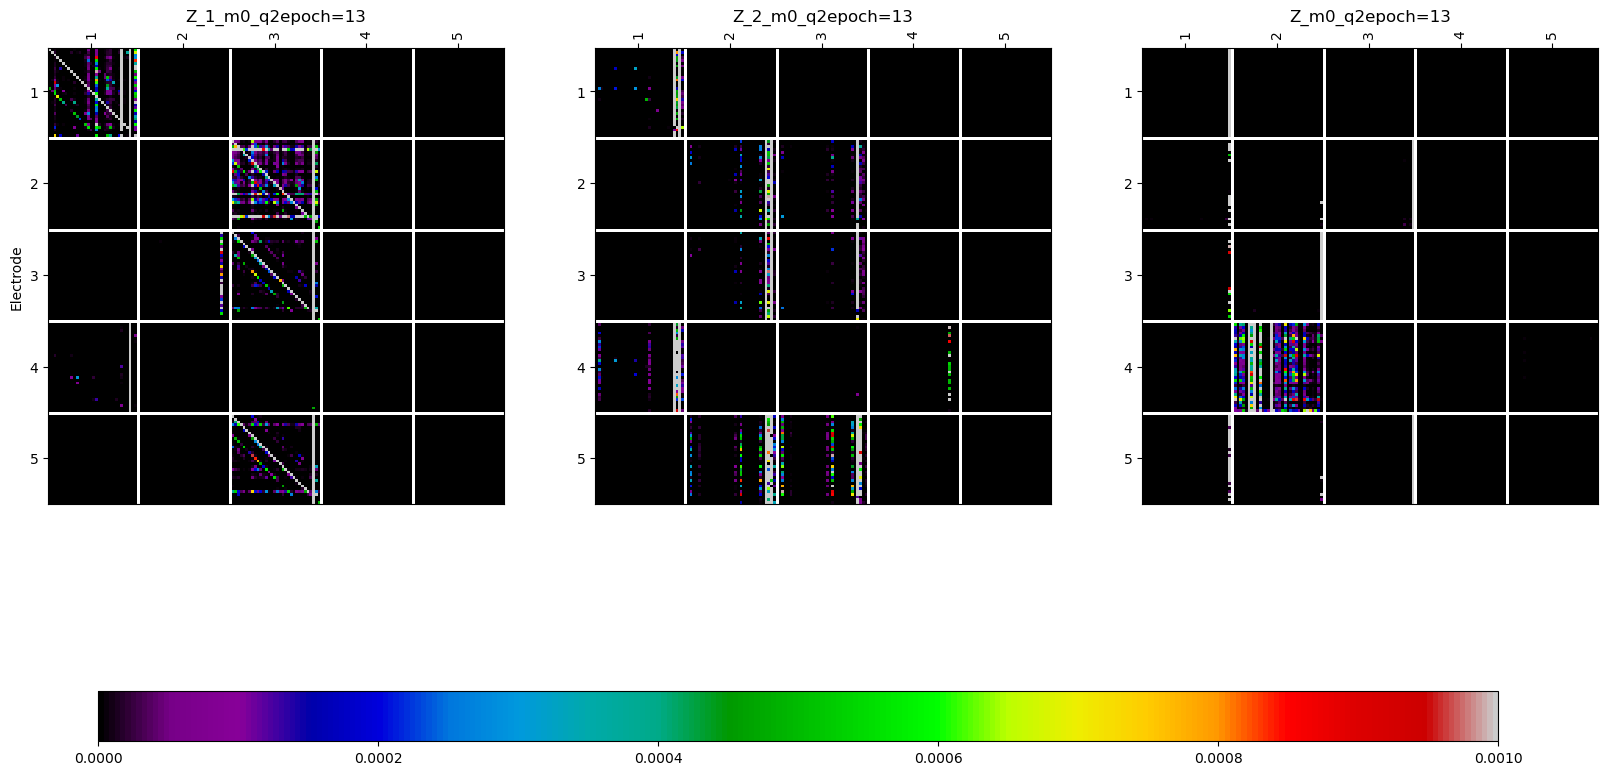

In [116]:
%matplotlib inline

attentions = []

titles = []
for name, value in attn_mse_ordered['Z']['0'].items():
    # get basename
    basename = os.path.basename(name)
    basename = basename.replace(".ckpt", "")
    # get the attention matrix
    attn = value[0]
    attn = attn[:, 0, :, :].mean(axis=0)
    # attn = attn[5, 0, :, :]
    attentions.append(attn)
    titles.append(basename)

names = ["1,2,3,4,5".split(',')] * len(attentions)
combined_plot(attentions, names, titles, 32, same_order=True, plot_size=(20,10), maxval=0.001);

In [98]:
def collapse_to_sumwave(attention, context):
    # break into sub chunks and sum across column
    chunks = attention.shape[0] // context
    sums = []
    for X in range(chunks):
        for Y in range(chunks):
            subset = get_sub_matrices(attention, context, [(X,Y)])[0]
            # break into "waves"
            sums.append(np.sum(subset, axis=0))
    return sums

In [108]:
max_y = 32

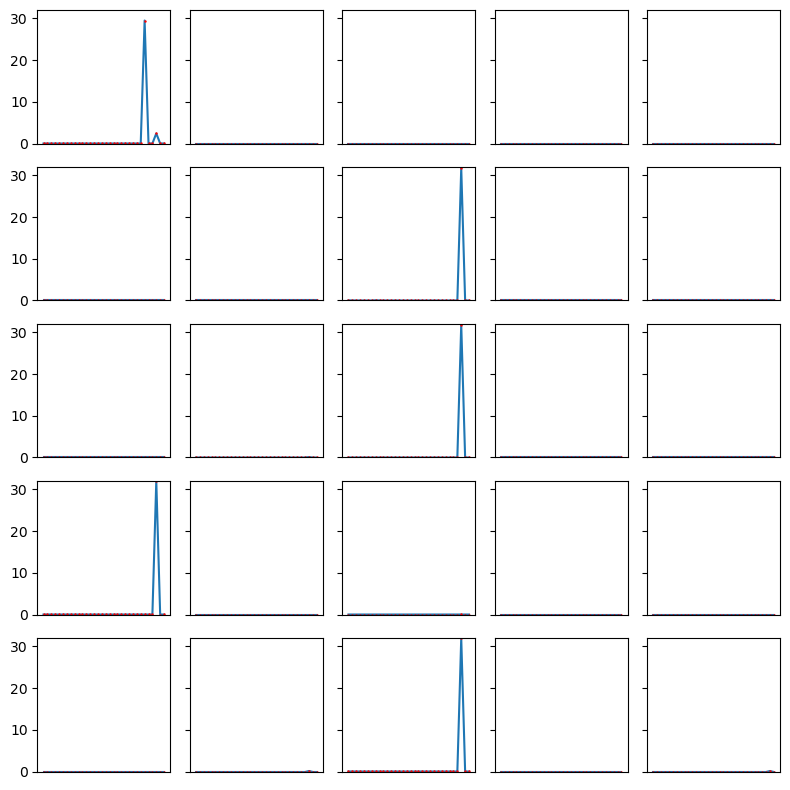

In [117]:
s = collapse_to_sumwave(attentions[0], max_y)
blocks = int(np.sqrt(len(s)))
fig,ax = plt.subplots(blocks,blocks,figsize=(8,8),sharex=True, sharey=True)
for x in range(blocks):
    for y in range(blocks):
        ax[x,y].plot(s[x*blocks+y],'-')
        ax[x,y].plot(s[x*blocks+y],'.', color='red', markersize=1.5)
        # ax[x,y].set_title(f"Block {x*blocks+y+1}")
        ax[x,y].set_ylim(0,max_y)
        ax[x,y].set_xticks([])
        # ax[x,y].set_yticks([])
plt.tight_layout()

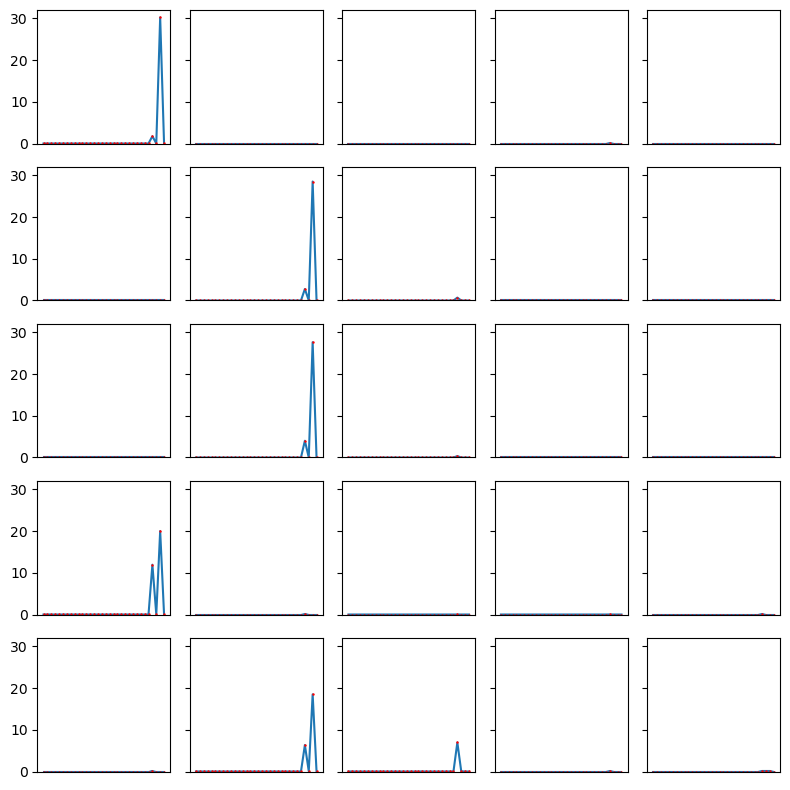

In [110]:
s = collapse_to_sumwave(attentions[1], max_y)
blocks = int(np.sqrt(len(s)))
fig,ax = plt.subplots(blocks,blocks,figsize=(8,8),sharex=True, sharey=True)
for x in range(blocks):
    for y in range(blocks):
        ax[x,y].plot(s[x*blocks+y],'-')
        ax[x,y].plot(s[x*blocks+y],'.', color='red', markersize=1.5)
        # ax[x,y].set_title(f"Block {x*blocks+y+1}")
        ax[x,y].set_ylim(0,max_y)
        ax[x,y].set_xticks([])
        # ax[x,y].set_yticks([])
plt.tight_layout()

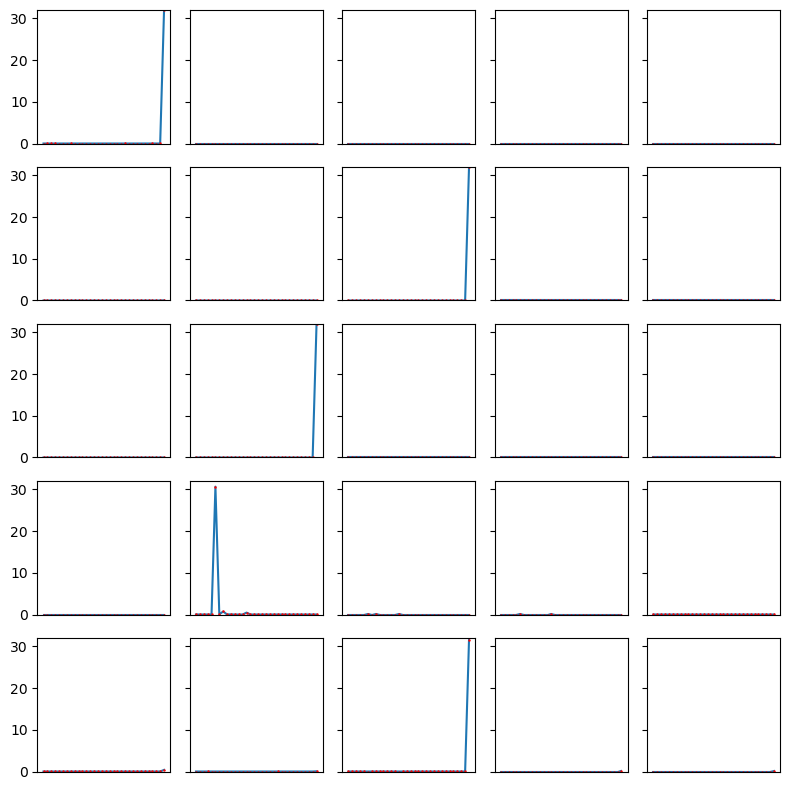

In [111]:
s = collapse_to_sumwave(attentions[2], max_y)
blocks = int(np.sqrt(len(s)))
fig,ax = plt.subplots(blocks,blocks,figsize=(8,8),sharex=True, sharey=True)
for x in range(blocks):
    for y in range(blocks):
        ax[x,y].plot(s[x*blocks+y],'-')
        ax[x,y].plot(s[x*blocks+y],'.', color='red', markersize=1.5)
        # ax[x,y].set_title(f"Block {x*blocks+y+1}")
        ax[x,y].set_ylim(0,max_y)
        ax[x,y].set_xticks([])
        # ax[x,y].set_yticks([])
plt.tight_layout()

In [112]:
# diff = np.square(np.diff(value[0].squeeze(),axis=0)).sum(axis=0)
# names = ["1,2,3,4,5".split(',')] *2
# mean = value[0].squeeze().mean(axis=0)
# combined_plot([diff,mean], names, ['diff','mean'], 32, same_order=True, plot_size=(10,5));

Text(0, 0.5, '1')

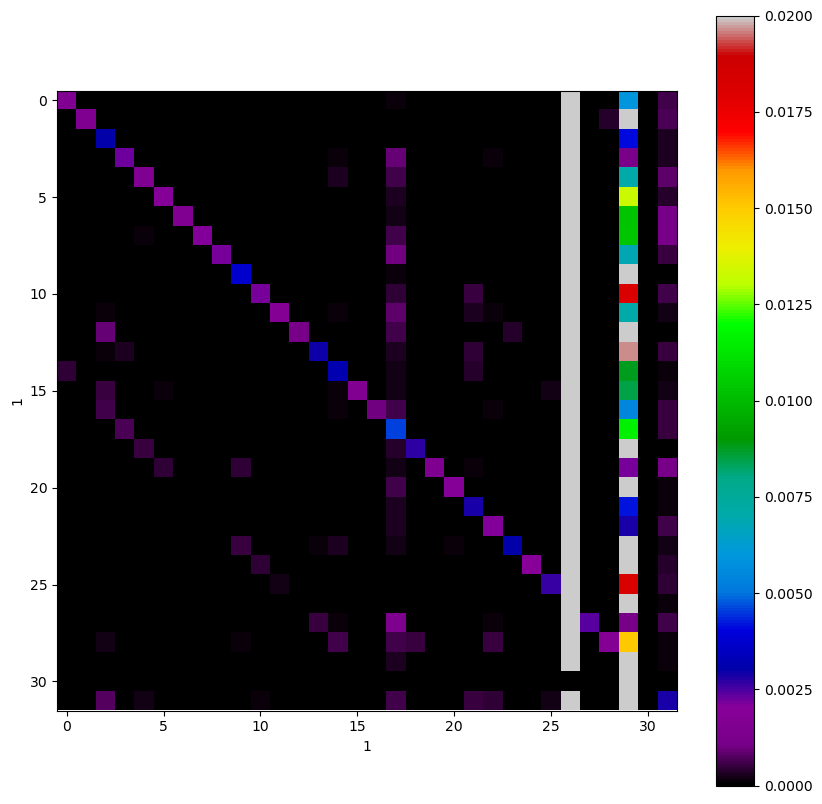

In [113]:
X = 0
Y = 0
a = get_sub_matrices(attentions[0], 32, [(X,Y)])[0]
plt.figure(figsize=(10,10))
plt.imshow(a, cmap='nipy_spectral', interpolation='none', vmin=0, vmax=.02)
plt.colorbar()
plt.xlabel(names[0][X])
plt.ylabel(names[0][Y])